In [5]:
import sys
sys.path.append("..")

# November 17th

Recap from last week:

- plotted setup vs Hs with tide --> found that low tide produces higher setup per Hs
- in autospectra, found that smaller 12-25 had a low frequency "hump" not seen on bigger swell days. Wth is that. 
- plotted time-frequency coherence between sensor 6 and sensor 1. Just for the hell of it, overlayed tidal range on top to see if there's a correlation... probs not. 

Reccos from MM:

- Complex demodulation
- pequignet's paper for something with IG waves 

#### Plot smaller events to investigate low frequency 'hump'

In [7]:
import pandas as pd
import numpy as np
import xarray as xr
from src.spectra import Spp_to_Seta
from scipy.signal import spectrogram

df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')



def sensor_spectra(df, nperseg = 3600 * 48, noverlap = 0.5):
    ''' 
    Computes spectra of a sensor's dataframe and returns an xarray dataset.
    Applies a hanning window with linear detrending to compute PSD

    ----- Parameters ------
    df: pandas dataframe (with p as a column)
    nperseg: number of segments for spectra
    noverlap: percent overlap of spectral windows
    
    '''
    nperseg = nperseg
    noverlap = 0.5 * nperseg

    yy = df['p']
    # get sampling rate from the index
    dt = np.median(np.diff(yy.index.view('int64'))) / 1e9  # seconds (int64 ns → s)
    fs = 1.0 / dt
    # compute spectra 
    f, t_spec, Spp = spectrogram(
    yy.values, 
        fs=fs, 
        window = 'hann',
        nperseg = nperseg,
        noverlap=noverlap,
        detrend='linear',
        scaling='density',
        mode='psd',
    )
    # Spp_to_Seta converts to surface elevation using transfer function from Falk's notes
    Sn, t, h = Spp_to_Seta(Spp, f, t_spec, df.index.values, df['h'].values)
    # collect variables into an xarray dataset
    S = xr.Dataset(
        data_vars={
            "Seta": (("frequency", "time"), Sn),
            "h_mean": (("time",), h),
        },
        coords={
            "frequency": xr.DataArray(f, dims="frequency", attrs={"units": "Hz"}),
            "time": xr.DataArray(t, dims="time", attrs={"long_name": "spectral time axis"}),
        },
        attrs={"source": "Spp_to_Seta output"},
    )
    return S

S1 = sensor_spectra(df1)
S6 = sensor_spectra(df6)


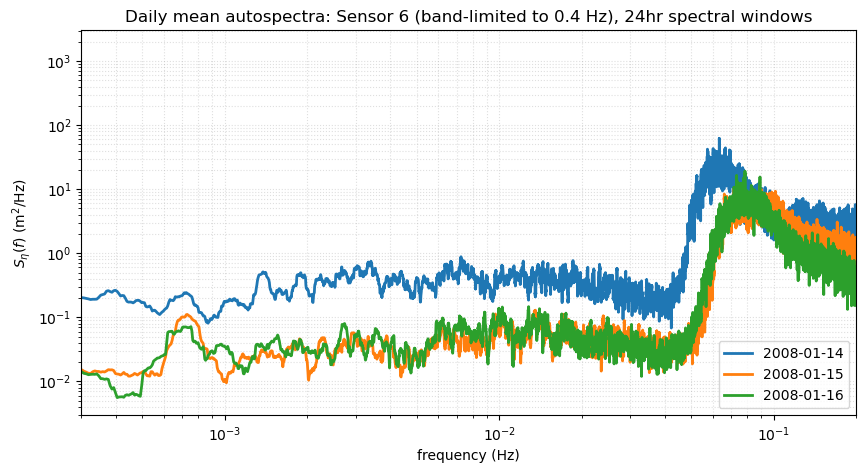

In [11]:
import matplotlib.pyplot as plt

# input dates/sensor dataset to analyze as well as frequency bands 
ds = S6
dayA, dayB, dayC = "2008-01-14", "2008-01-15", '2008-01-16'
fmin, fmax = 0.0000001, 0.40   # band-limit to cut noise

def day_spectrum(ds, day, agg="mean"):
    sel = ds.sel(time=slice(f"{day}T00:00", f"{day}T23:59"))
    # daily mean (or median) autospectrum, band-limited
    S = sel.Seta.sel(frequency=slice(fmin, fmax))
    return (S.mean("time") if agg == "mean" else S.median("time"))

S_A = day_spectrum(ds, dayA, agg="mean")
S_B = day_spectrum(ds, dayB, agg="mean")
S_C = day_spectrum(ds, dayC, agg="mean")

# optional light smoothing in frequency 
S_A = S_A.rolling(frequency=25, center=True).mean()
S_B = S_B.rolling(frequency=25, center=True).mean()
S_C = S_C.rolling(frequency=25, center=True).mean()

fig, ax = plt.subplots(figsize=(10,5))
ax.loglog(S_A.frequency, S_A, label=dayA, lw=2)
ax.loglog(S_B.frequency, S_B, label=dayB, lw=2)
ax.loglog(S_C.frequency, S_C, label=dayC, lw=2)

ax.set_xlim(0.0003, 0.2)
#ax.set_ylim(0.0, 10)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel(r"$S_{\eta}(f)$ (m$^2$/Hz)")
ax.set_title(f"Daily mean autospectra: Sensor 6 (band-limited to {fmax} Hz), 24hr spectral windows")
ax.grid(True, which="both", ls=":", alpha=0.4)
ax.legend(loc='lower right')
plt.show()

In [21]:
fmin, fmax = 0.01, 0.1

# restrict to swell band
S_band = S_A.sel(frequency=slice(fmin, fmax))

# compute index of maximum along frequency
idx = S_band.argmax(dim="frequency")

# select frequency corresponding to max value
f_peak = S_band.frequency.isel(frequency=idx)
f_peak

<xarray.DataArray 'frequency' ()> Size: 8B
array(0.06330991)
Coordinates:
    frequency  float64 8B 0.06331
Attributes:
    units:    Hz

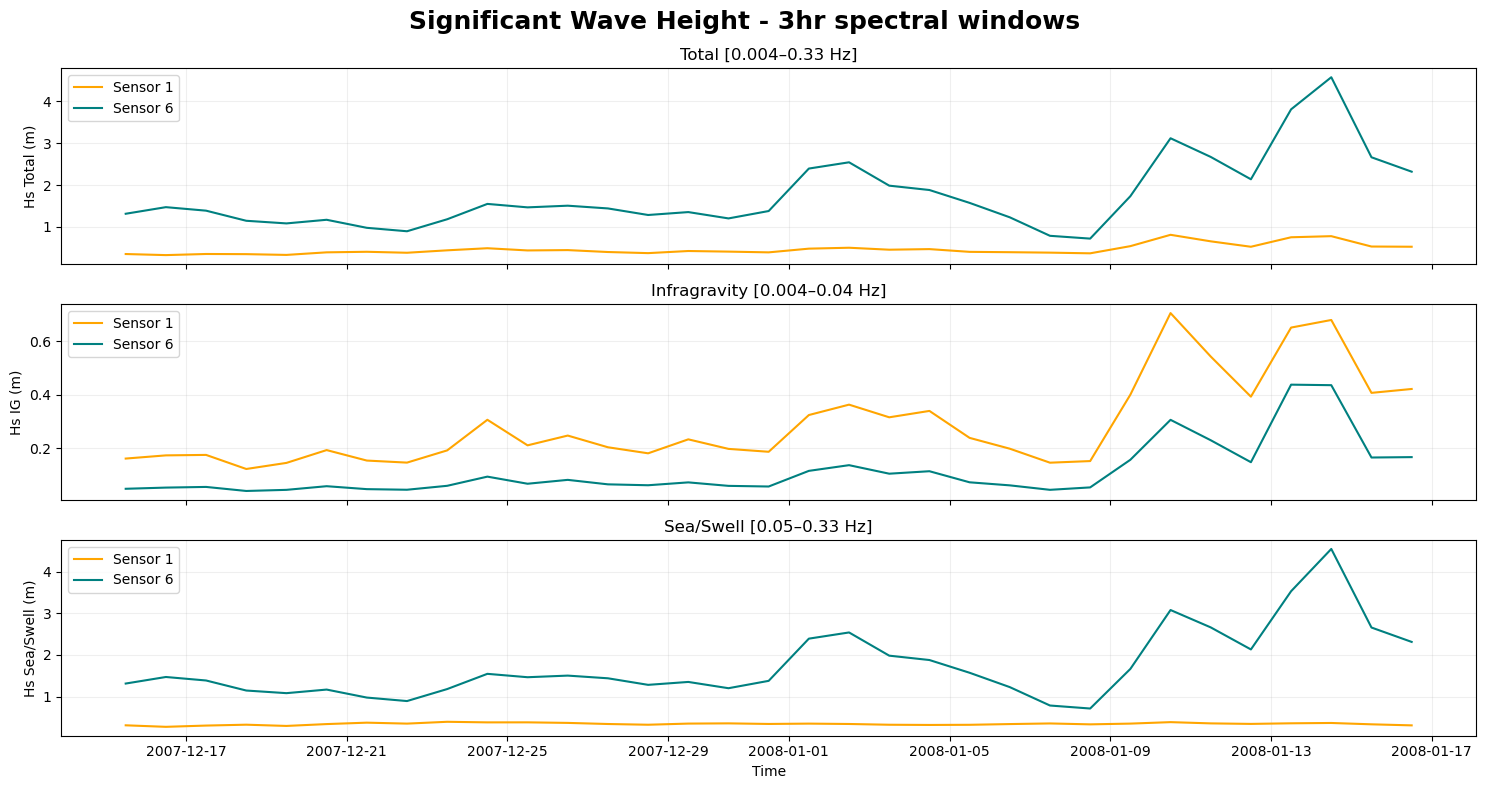

In [ ]:
def Hs_band(ds, fmin=None, fmax=None):
    da = ds.Seta if (fmin is None and fmax is None) else ds.Seta.sel(frequency=slice(fmin, fmax))
    m0 = da.integrate("frequency")                 # ∫ S_eta df  -> (time,)
    return 4.0 * np.sqrt(m0) 

# time cutoff 
TMAX = np.datetime64("2008-02-17")

# 1) slice datasets BEFORE TMAX
ds1_pre = S1.where(S1.time < TMAX, drop=True)
ds6_pre = S6.where(S6.time < TMAX, drop=True)

IG = (0.004, 0.04); SS = (0.05, 0.33); TOT = (0.004, 0.33)

Hs1_tot = Hs_band(ds1_pre, *TOT); Hs1_ig = Hs_band(ds1_pre, *IG); Hs1_ss = Hs_band(ds1_pre, *SS)
Hs6_tot = Hs_band(ds6_pre, *TOT); Hs6_ig = Hs_band(ds6_pre, *IG); Hs6_ss = Hs_band(ds6_pre, *SS)

# 3) align Sensor 6 to Sensor 1 times (nearest)
dt_sec = np.median(np.diff(ds1_pre.time.values).astype("timedelta64[s]").astype(float))
tol = pd.Timedelta(seconds=float(dt_sec)/2 if dt_sec > 0 else 1200)

s1_tot = pd.Series(Hs1_tot.values, index=pd.to_datetime(Hs1_tot.time.values))
s1_ig  = pd.Series(Hs1_ig.values,  index=pd.to_datetime(Hs1_ig.time.values))
s1_ss  = pd.Series(Hs1_ss.values,  index=pd.to_datetime(Hs1_ss.time.values))

s6_tot = pd.Series(Hs6_tot.values, index=pd.to_datetime(Hs6_tot.time.values)).reindex(s1_tot.index, method="nearest", tolerance=tol)
s6_ig  = pd.Series(Hs6_ig.values,  index=pd.to_datetime(Hs6_ig.time.values)).reindex(s1_ig.index,   method="nearest", tolerance=tol)
s6_ss  = pd.Series(Hs6_ss.values,  index=pd.to_datetime(Hs6_ss.time.values)).reindex(s1_ss.index,   method="nearest", tolerance=tol)

mask = s6_tot.notna() & s6_ig.notna() & s6_ss.notna()
t_aligned   = s1_tot.index[mask]
Hs1_tot_aln = s1_tot[mask].values; Hs6_tot_aln = s6_tot[mask].values
Hs1_ig_aln  = s1_ig [mask].values; Hs6_ig_aln  = s6_ig [mask].values
Hs1_ss_aln  = s1_ss [mask].values; Hs6_ss_aln  = s6_ss [mask].values

# 4) plot 
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
fig.suptitle("Significant Wave Height - 3hr spectral windows", fontsize=18, weight="bold")

axes[0].plot(t_aligned, Hs1_tot_aln, label="Sensor 1", color="orange")
axes[0].plot(t_aligned, Hs6_tot_aln, label="Sensor 6", color="teal")
axes[0].set_ylabel("Hs Total (m)"); axes[0].set_title("Total [0.004–0.33 Hz]")
axes[0].grid(True, alpha=0.2); axes[0].legend(loc="upper left")

axes[1].plot(t_aligned, Hs1_ig_aln, label="Sensor 1", color="orange")
axes[1].plot(t_aligned, Hs6_ig_aln, label="Sensor 6", color="teal")
axes[1].set_ylabel("Hs IG (m)"); axes[1].set_title("Infragravity [0.004–0.04 Hz]")
axes[1].grid(True, alpha=0.2); axes[1].legend(loc="upper left")

axes[2].plot(t_aligned, Hs1_ss_aln, label="Sensor 1", color="orange")
axes[2].plot(t_aligned, Hs6_ss_aln, label="Sensor 6", color="teal")
axes[2].set_ylabel("Hs Sea/Swell (m)"); axes[2].set_title("Sea/Swell [0.05–0.33 Hz]")
axes[2].grid(True, alpha=0.2); axes[2].legend(loc="upper left")
axes[2].set_xlabel("Time")

plt.tight_layout(); plt.show()


so after playing around with the size of the spectral window. It seems that 12 hour windows smooth out the size of the low freq hump. However, 24 hour windows do not. What frequency is this that produces a hump ?

In [295]:
start = "2007-12-24"
end   = "2007-12-25" 

S1_day = S1.sel(time=slice(start,end))
S6_day = S6.sel(time=slice(start, end))
f_eta = S6_day.frequency.values                   # (n_freq,)
S_eta = S6_day.Seta.mean(dim="time").values       # time-mean S_eta(f)

# Find hump inVLF band, 
mask_vlf = (f_eta >= 1e-4) & (f_eta <= 1e-2)
f_hump = f_eta[mask_vlf][np.argmax(S_eta[mask_vlf])]
print("Frequency of hump is ", f_hump, 'hz')
print("Period of hump is ", 1/f_hump / 60, "min")


Frequency of hump is  0.0007060154459392978 hz
Period of hump is  23.606660112786884 min


ok was definitely not expecting the hump to be a 24h period

#### Complex Demodulation

Applying this process to sea/swell band to extract envelopes, instantaneous amplitudes, and instantaneous phase/freq of wave groups. 

**STEPS**
1. get dominant swell freq from spectrum 
2. band pass filter
3. demodulate (multpily by complex expnential)
4. low pass filter to keep only slow modulation
5. envelope and phase 

In [262]:
from scipy.signal import welch, butter, filtfilt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [263]:
# choose the date to inspect
start = "2007-12-24"
end   = "2007-12-25" 
df6_day = df6.loc[start:end].copy()
# extract pressure and time
p = df6_day['p'].to_numpy()
t_idx = df6_day.index
fs = 1 # Hz
# time in seconds since start
t_int = t_idx.view("int64")
t_sec = ((t_int - t_int[0]) / 1e9).astype(float)

# compute spectra, average over time
f_spec, t_spec, S = spectrogram(p, fs=fs, window='hann', nperseg=4096, noverlap=2048, detrend='linear', scaling='density', mode='psd')
Pxx_avg = S.mean(axis=1)

# find peak freq in swell band
fmin, fmax  = (0.05, 0.15)
mask = (f_spec >= fmin) & (f_spec <= fmax)
f0 = f_spec[mask][np.argmax(Pxx_avg[mask])]

# band pass filter to isolate the swell band 
nyq = fs / 2.0
b_bp, a_bp = butter(4, [fmin/nyq, fmax/nyq], btype="band")

x_ss = filtfilt(b_bp, a_bp, p) 

carrier = np.exp(-1j * 2 * np.pi * f0 * t_sec)
x_demod = x_ss * carrier 

# carrier show now be at 0hz 
# now low pass filer so envelope varys on >50s timescale
f_mod_max = 0.02      # Hz  (period = 50 s)
b_lp, a_lp = butter(4, f_mod_max/nyq, btype="low")

z = filtfilt(b_lp, a_lp, x_demod)   # complex envelope
A = np.abs(z)                    # amplitude envelope (group envelope)
phi = np.unwrap(np.angle(z))     # demodulated phase
E = (A-A.mean())**2


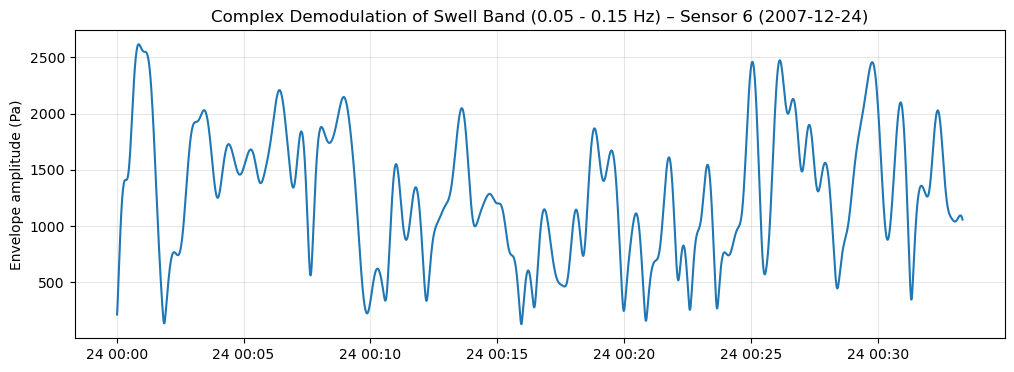

In [264]:
A_series = pd.Series(A, index=t_idx, name="A_envelope")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(A_series.index[0:2000], A_series.values[0:2000])
ax.set_ylabel("Envelope amplitude (Pa)")
ax.set_title("Complex Demodulation of Swell Band (0.05 - 0.15 Hz) – Sensor 6 (2007-12-24)")
ax.grid(True, which="both", alpha=0.3)


Text(0.5, 1.0, 'Does slow varying envelope of swell band explain the VLF hump?')

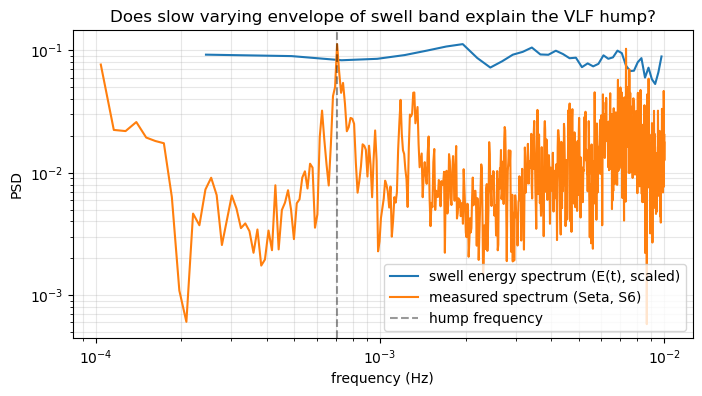

In [265]:
f_E, t_E, S_E = spectrogram(
    E,
    fs=fs,
    window="hann",
    nperseg=4096,
    noverlap=2048,
    detrend="constant",
    scaling="density",
    mode="psd",
)
S_E_mean = S_E.mean(axis=1)   # E(t) spectrum vs f

mask_vlf_E   = (f_E   >= 1e-4) & (f_E   <= 1e-2)
mask_vlf_eta = (f_eta >= 1e-4) & (f_eta <= 1e-2)

plt.figure(figsize=(8,4))

# scale E spectrum to overlay shapes (just for visual)
scale = S_eta[mask_vlf_eta].max() / S_E_mean[mask_vlf_E].max()
plt.loglog(f_E[mask_vlf_E], S_E_mean[mask_vlf_E] * scale,
           label="swell energy spectrum (E(t), scaled)")
plt.loglog(f_eta[mask_vlf_eta], S_eta[mask_vlf_eta],
           label="measured spectrum (Seta, S6)")

plt.axvline(f_hump, color="k", ls="--", alpha=0.4, label="hump frequency")
plt.xlabel("frequency (Hz)")
plt.ylabel("PSD")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.title("Does slow varying envelope of swell band explain the VLF hump?")


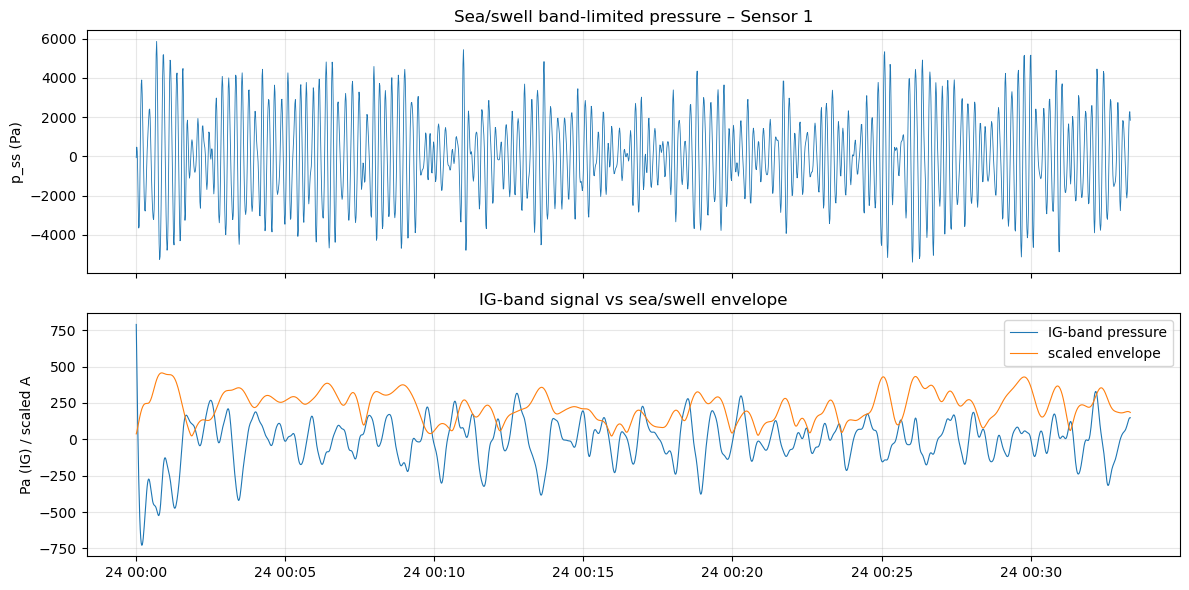

In [266]:
f_lo_ig = 0.004
f_hi_ig = 0.04

b_ig, a_ig = butter(4, [f_lo_ig/nyq, f_hi_ig/nyq], btype="band")
x_ig = filtfilt(b_ig, a_ig, p)

IG_series = pd.Series(x_ig, index=t_idx, name="p_IG")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)

# sea/swell band-limited signal (just to see what we're modulating)
ax1.plot(t_idx[0:2000], x_ss[0:2000], lw=0.6)
ax1.set_ylabel("p_ss (Pa)")
ax1.set_title("Sea/swell band-limited pressure – Sensor 1")
ax1.grid(True, alpha=0.3)

# IG vs envelope (scaled so they fit on same axis)
scale = np.max(np.abs(IG_series.values)) / np.max(A_series.values)
ax2.plot(t_idx[0:2000], IG_series.values[0:2000], label="IG-band pressure", lw=0.8)
ax2.plot(t_idx[0:2000], A_series.values[0:2000] * scale, label="scaled envelope", lw=0.8)
ax2.set_ylabel("Pa (IG) / scaled A")
ax2.set_title("IG-band signal vs sea/swell envelope")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()



#### Continuing down the rabbit hole of the VLF hump...

##### Comparing S1 vs S6 VLF humps

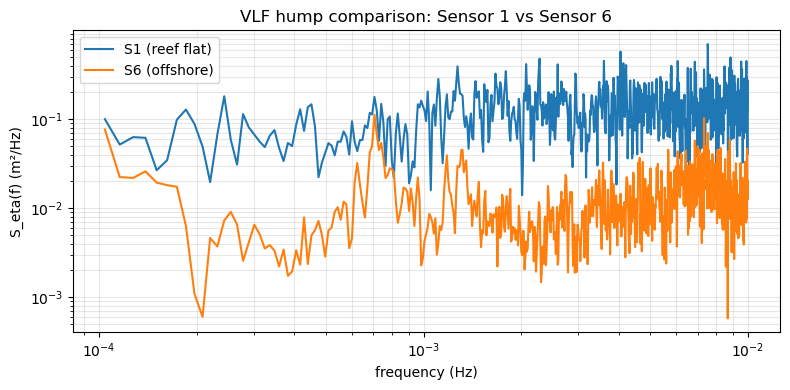

In [267]:
start = "2007-12-24"
end   = "2007-12-25" 

S1_day = S1.sel(time=slice(start,end))
S6_day = S6.sel(time=slice(start, end))

# low freqss
f_min = 1e-4
f_max = 1e-2

# Find hump inVLF band, 
mask_vlf = (f_eta >= f_min) & (f_eta <= f_max)
f_hump = f_eta[mask_vlf][np.argmax(S_eta[mask_vlf])]

# daily mean spectra
f1  = S1_day.frequency.values
S1m = S1_day.Seta.mean(dim="time").values

f6  = S6_day.frequency.values
S6m = S6_day.Seta.mean(dim="time").values

# mask VLF range
mask1 = (f1 >= f_min) & (f1 <= f_max)
mask6 = (f6 >= f_min) & (f6 <= f_max)

plt.figure(figsize=(8,4))
plt.loglog(f1[mask1], S1m[mask1], label="S1 (reef flat)")
plt.loglog(f6[mask6], S6m[mask6], label="S6 (offshore)")

plt.xlabel("frequency (Hz)")
plt.ylabel("S_eta(f) (m²/Hz)")
plt.title("VLF hump comparison: Sensor 1 vs Sensor 6")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()


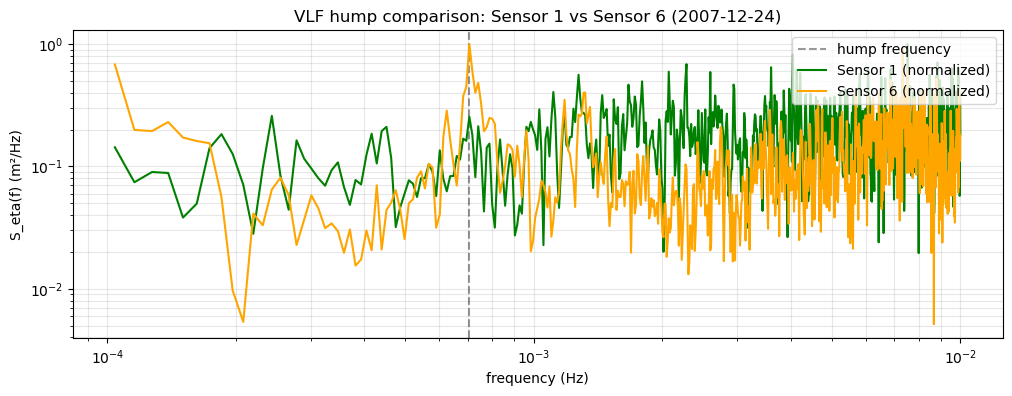

In [268]:
S1_norm = S1m[mask1] / np.nanmax(S1m[mask1])
S6_norm = S6m[mask6] / np.nanmax(S6m[mask6])

plt.figure(figsize=(12,4))

plt.title(f"VLF hump comparison: Sensor 1 vs Sensor 6 ({start})")
plt.axvline(f_hump, color="k", ls="--", alpha=0.4, label="hump frequency")

plt.loglog(f1[mask1], S1_norm, label="Sensor 1 (normalized)", color = 'green')
plt.loglog(f6[mask6], S6_norm, label="Sensor 6 (normalized)", color = 'orange')
plt.legend(loc='upper right')
plt.xlabel("frequency (Hz)")
plt.ylabel("S_eta(f) (m²/Hz)")
plt.grid(True, which="both", alpha=0.3)


In [270]:
import numpy as np

def get_hump_frequency(S, start, end, f_min=1e-4, f_max=1e-2):
    """
    Given an xarray spectrum dataset S (with coords frequency, time),
    and a date range, return the hump frequency in the VLF band.
    """
    S_day = S.sel(time=slice(start, end))
    f = S_day.frequency.values
    S_mean = S_day.Seta.mean(dim="time").values
    
    mask = (f >= f_min) & (f <= f_max)
    
    if np.sum(mask) == 0:
        return np.nan
    
    f_band = f[mask]
    S_band = S_mean[mask]
    
    # hump frequency = frequency of max PSD in that VLF band
    idx = np.argmax(S_band)
    return f_band[idx]

def get_daily_tide(df, start, end):
    """
    Return the mean tide level (h_tide) for a specific date range.
    """
    day = df.loc[start:end]
    return day['h_tide'].mean()

import pandas as pd

dates = pd.date_range("2007-12-14", "2008-01-15", freq="1D")

hump_freqs = []
tide_levels = []

for d in dates:
    start = d.strftime("%Y-%m-%d")
    end   = (d + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
    
    f_hump = get_hump_frequency(S6, start, end)
    tide   = get_daily_tide(df6, start, end)
    
    hump_freqs.append(f_hump)
    tide_levels.append(tide)



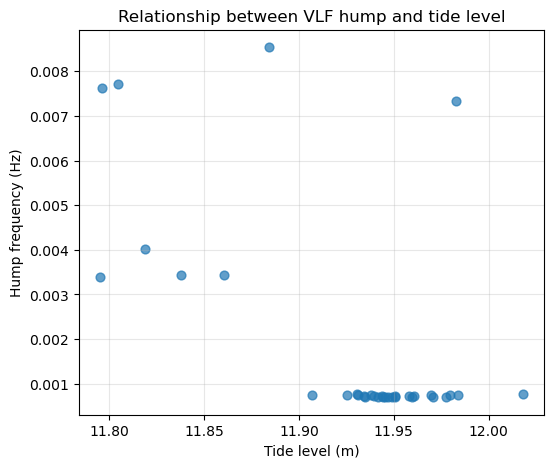

In [271]:
plt.figure(figsize=(6,5))
plt.scatter(tide_levels, hump_freqs, s=40, alpha=0.7)
plt.xlabel("Tide level (m)")
plt.ylabel("Hump frequency (Hz)")
plt.title("Relationship between VLF hump and tide level")
plt.grid(alpha=0.3)


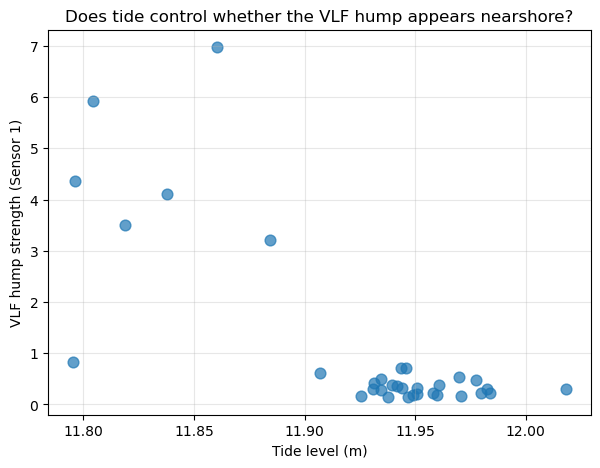

In [272]:
def VLF_hump_power(S, start, end, f_lo=1e-4, f_hi=3e-3):
    """
    Return the strength of the VLF hump at one sensor
    by computing the maximum PSD in the VLF band.
    """
    S_day = S.sel(time=slice(start, end))
    f = S_day.frequency.values
    Smean = S_day.Seta.mean(dim="time").values

    mask = (f >= f_lo) & (f <= f_hi)

    if mask.sum() == 0:
        return np.nan

    return np.max(Smean[mask])     # hump "strength"

#return np.trapz(Smean[mask], f[mask])

def daily_tide(df, start, end):
    d = df.loc[start:end]
    return d['h_tide'].mean()

import pandas as pd
import numpy as np

dates = pd.date_range("2007-12-14", "2008-01-15", freq="1D")

hump_S1 = []
tide_vals = []
valid_dates = []

for d in dates:
    start = d.strftime("%Y-%m-%d")
    end   = (d + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

    power = VLF_hump_power(S1, start, end)
    tide  = daily_tide(df6, start, end)

    if not np.isnan(power):
        hump_S1.append(power)
        tide_vals.append(tide)
        valid_dates.append(start)


plt.figure(figsize=(7,5))
plt.scatter(tide_vals, hump_S1, s=60, alpha=0.7)
plt.xlabel("Tide level (m)")
plt.ylabel("VLF hump strength (Sensor 1)")
plt.title("Does tide control whether the VLF hump appears nearshore?")
plt.grid(alpha=0.3)



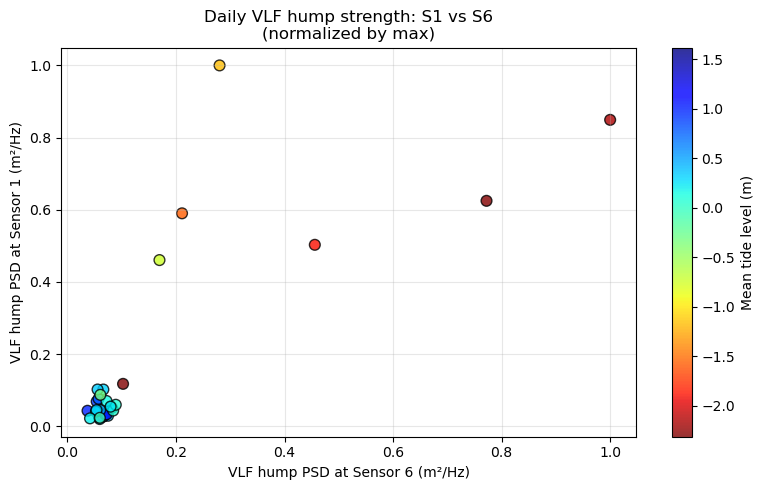

In [283]:
import numpy as np

def vlf_hump_stats(S, start, end, f_lo=1e-4, f_hi=3e-3):
    """
    For a given xarray spectrum S (with coords frequency, time)
    and a date range, return:
      - f_hump : frequency of max PSD in VLF band
      - S_hump: PSD value at that frequency
    """
    S_day = S.sel(time=slice(start, end))
    f = S_day.frequency.values
    Smean = S_day.Seta.mean(dim="time").values

    mask = (f >= f_lo) & (f <= f_hi)
    if mask.sum() == 0:
        return np.nan, np.nan

    f_band = f[mask]
    S_band = Smean[mask]

    idx = np.argmax(S_band)
    return f_band[idx], S_band[idx]
def daily_tide(df, start, end):
    day = df.loc[start:end]
    return day["h_tide"].mean()

import pandas as pd

dates = pd.date_range("2007-12-14", "2008-01-15", freq="1D")

S1_hump_PSD = []
S6_hump_PSD = []
tide_vals   = []
valid_dates = []

for d in dates:
    start = d.strftime("%Y-%m-%d")
    end   = (d + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

    f1, S1h = vlf_hump_stats(S1, start, end)
    f6, S6h = vlf_hump_stats(S6, start, end)
    tide    = daily_tide(df6, start, end)   # or df1 if you prefer

    # skip days with NaNs
    if np.isfinite(S1h) and np.isfinite(S6h):
        S1_hump_PSD.append(S1h)
        S6_hump_PSD.append(S6h)
        tide_vals.append(tide)
        valid_dates.append(start)


import matplotlib.pyplot as plt

S1_arr = np.array(S1_hump_PSD)
S6_arr = np.array(S6_hump_PSD)
tide_arr = np.array(tide_vals)

S6_norm = S6_arr / np.nanmax(S6_arr)
S1_norm = S1_arr / np.nanmax(S1_arr)

plt.figure(figsize=(8,5))
sc = plt.scatter(S6_norm, S1_norm, c=tide_norm, cmap="jet_r", s=60, edgecolor="k", alpha=0.8)
plt.xlabel("VLF hump PSD at Sensor 6 (m²/Hz)")
plt.ylabel("VLF hump PSD at Sensor 1 (m²/Hz)")
plt.title("Daily VLF hump strength: S1 vs S6\n(normalized by max)")
cbar = plt.colorbar(sc)
cbar.set_label("Mean tide level (m)")
plt.grid(alpha=0.3)
plt.tight_layout()





In [274]:
start = "2007-12-24"
end   = "2007-12-25" 

S1_day = S1.sel(time=slice(start,end))
S6_day = S6.sel(time=slice(start, end))
f_eta = S6_day.frequency.values                   # (n_freq,)
S_eta = S6_day.Seta.mean(dim="time").values       # time-mean S_eta(f)

# Find hump inVLF band, 
mask_vlf = (f_eta >= 1e-4) & (f_eta <= 1e-2)
f_hump = f_eta[mask_vlf][np.argmax(S_eta[mask_vlf])]
print("Frequency of hump is ", f_hump, 'hz')
print("Period of hump is ", 1/f_hump / 60, "min")

Frequency of hump is  0.0007060154459392978 hz
Period of hump is  23.606660112786884 min


using the hump from 12-24 as the reference VLF hump. Now for any day, sample the PSD at fhump

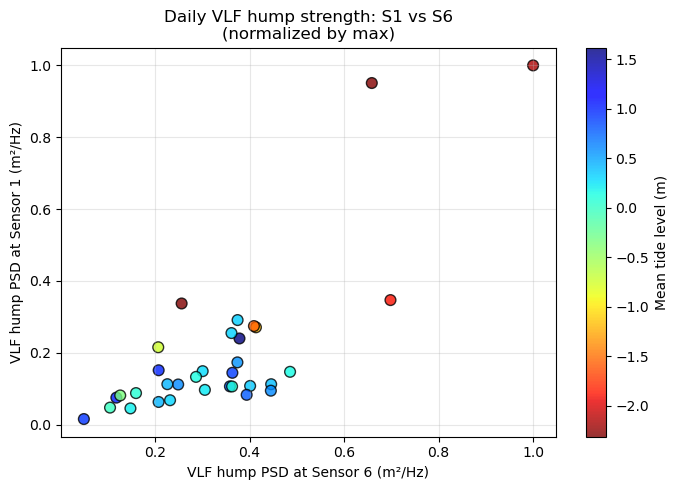

In [281]:
import numpy as np

def psd_at_ref_hump(S, start, end, f_ref):
    """
    Return the PSD at the reference hump frequency f_ref
    for a given sensor spectrum S over [start, end].
    """
    S_day = S.sel(time=slice(start, end))
    f = S_day.frequency.values
    S_mean = S_day.Seta.mean(dim="time").values

    # nearest frequency bin to f_ref
    idx = np.argmin(np.abs(f - f_ref))
    return f[idx], S_mean[idx]


def daily_tide(df, start, end):
    day = df.loc[start:end]
    return day["h_tide"].mean()


dates = pd.date_range("2007-12-14", "2008-01-15", freq="1D")

S1_hump_PSD = []
S6_hump_PSD = []
tide_vals   = []
valid_dates = []

for d in dates:
    start = d.strftime("%Y-%m-%d")
    end   = (d + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

    _, S1h = psd_at_ref_hump(S1, start, end, f_hump)
    _, S6h = psd_at_ref_hump(S6, start, end, f_hump)
    tide   = daily_tide(df6, start, end)

    if np.isfinite(S1h) and np.isfinite(S6h):
        S1_hump_PSD.append(S1h)
        S6_hump_PSD.append(S6h)
        tide_vals.append(tide)
        valid_dates.append(start)

S1_arr = np.array(S1_hump_PSD)
S6_arr = np.array(S6_hump_PSD)
tide_arr = np.array(tide_vals)

S6_norm = S6_arr / np.nanmax(S6_arr)
S1_norm = S1_arr / np.nanmax(S1_arr)
tide_norm = (tide_arr - np.mean(tide_arr)) / np.std(tide_arr)


plt.figure(figsize=(7,5))
sc = plt.scatter(S6_norm, S1_norm, c=tide_norm, cmap="jet_r", s=60, edgecolor="k", alpha=0.8)
plt.xlabel("VLF hump PSD at Sensor 6 (m²/Hz)")
plt.ylabel("VLF hump PSD at Sensor 1 (m²/Hz)")
plt.title("Daily VLF hump strength: S1 vs S6\n(normalized by max)")
cbar = plt.colorbar(sc)
cbar.set_label("Mean tide level (m)")
plt.grid(alpha=0.3)
plt.tight_layout()




Wow, it sure looks like lower tide produces a stronger VLF hump . My theory here is that low tide produces more so partial standing modes may form and VLF energy can resonate more efficiently. notice all of the outliers are low tide. 

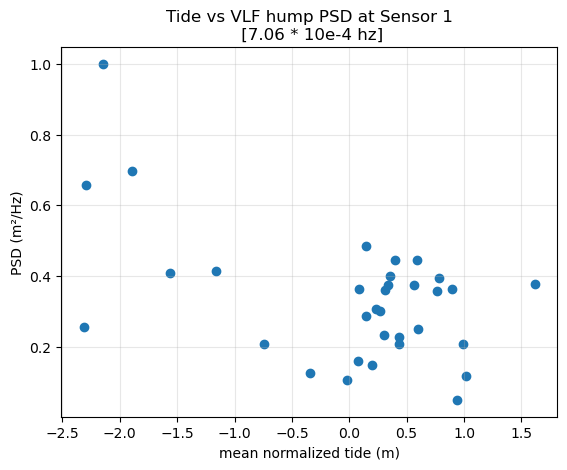

In [276]:
plt.scatter(tide_norm, S6_norm)
plt.title('Tide vs VLF hump PSD at Sensor 1\n [7.06 * 10e-4 hz]')
plt.xlabel('mean normalized tide (m)')
plt.ylabel("PSD (m²/Hz)")
plt.grid(True, alpha = 0.3)



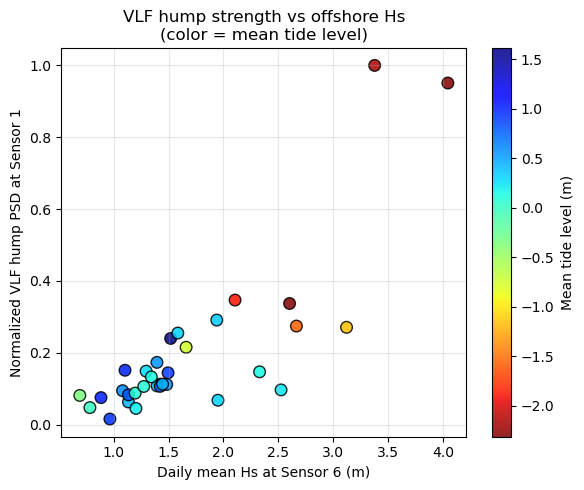

In [280]:
Hs6 = pd.Series(Hs6_tot_aln, index=pd.to_datetime(t_aligned))
Hs6_daily = Hs6.resample("1D").mean()

import pandas as pd
import numpy as np

dates_idx = pd.to_datetime(valid_dates)        # from your hump loop
Hs_for_days = Hs6_daily.reindex(dates_idx)     # same order as S1_hump_PSD

S1_arr   = np.array(S1_hump_PSD)
Hs_arr   = Hs_for_days.values


S1_norm = S1_arr / np.nanmax(S1_arr)
tide_norm = (tide_arr - np.mean(tide_arr)) / np.std(tide_arr)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sc = plt.scatter(Hs_arr, S1_norm, c=tide_norm, cmap="jet_r",
                 s=70, edgecolor="k", alpha=0.85)

plt.xlabel("Daily mean Hs at Sensor 6 (m)")
plt.ylabel("Normalized VLF hump PSD at Sensor 1")
plt.title("VLF hump strength vs offshore Hs\n(color = mean tide level)")
cbar = plt.colorbar(sc)
cbar.set_label("Mean tide level (m)")
plt.grid(alpha=0.3)
plt.tight_layout()

In [278]:
start = "2007-12-24"
end   = "2007-12-25" 

S1_day = S1.sel(time=slice(start,end))
S6_day = S6.sel(time=slice(start, end))
f_eta = S6_day.frequency.values                   # (n_freq,)
S_eta = S6_day.Seta.mean(dim="time").values       # time-mean S_eta(f)

# Find hump inVLF band, 
mask_vlf = (f_eta >= 1e-4) & (f_eta <= 1e-2)
f_hump = f_eta[mask_vlf][np.argmax(S_eta[mask_vlf])]
print("Frequency of hump is ", f_hump, 'hz')
print("Period of hump is ", 1/f_hump / 60, "min")


Frequency of hump is  0.0007060154459392978 hz
Period of hump is  23.606660112786884 min


Text(0, 0.5, 'tide')

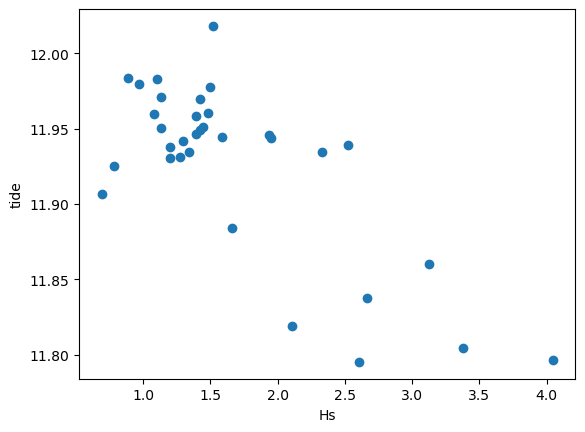

In [279]:
plt.scatter(Hs_arr, tide_arr)
plt.xlabel("Hs")
plt.ylabel('tide')